In this notebook, we use 165 features and a single LGBM model (not overly hypertuned) to provide a simple solution to this problem. You can increase the performance by adding more features, ensembling, hypertuning. It is noteworthy that there are less than 2500 samples in the dataset, so don't add alot features to avoid the dimensionality problem. Most of the features are based on the references below. Our addition is summed as follows:
* Bursts features.
* Ratio of final product length to keys pressed.
* Keys per second.
* A simple filter added to previously public features.

**Note that this notebook is currently at the 11th for efficiency track.**

References:
* https://www.kaggle.com/code/hengzheng/link-writing-simple-lgbm-baseline
* https://www.kaggle.com/code/mcpenguin/writing-processes-to-quality-baseline/notebook
* https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
* https://www.kaggle.com/code/hiarsl/feature-engineering-sentence-paragraph-features
* https://www.kaggle.com/code/kawaiicoderuwu/essay-contructor
* https://www.kaggle.com/code/yuriao/fast-essay-constructor

# Libraries

In [7]:
import polars as pl
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings("ignore")

# Polars FE & Helper Functions

In [16]:
num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
text_changes = ['q', ' ', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']


def count_by_values(df, colname, values):
    fts = df.select(pl.col('id').unique(maintain_order=True))
    for i, value in enumerate(values):
        tmp_df = df.group_by('id').agg(pl.col(colname).is_in([value]).sum().alias(f'{colname}_{i}_cnt'))
        fts  = fts.join(tmp_df, on='id', how='left') 
    return fts


def dev_feats(df):
    
    print("< Count by values features >")
    
    feats = count_by_values(df, 'activity', activities)
    feats = feats.join(count_by_values(df, 'text_change', text_changes), on='id', how='left') 
    feats = feats.join(count_by_values(df, 'down_event', events), on='id', how='left') 
    feats = feats.join(count_by_values(df, 'up_event', events), on='id', how='left') 

    print("< Input words stats features >")

    temp = df.filter((~pl.col('text_change').str.contains('=>')) & (pl.col('text_change') != 'NoChange'))
    temp = temp.group_by('id').agg(pl.col('text_change').str.concat('').str.extract_all(r'q+'))
    temp = temp.with_columns(input_word_count = pl.col('text_change').list.lengths(),
                             input_word_length_mean = pl.col('text_change').apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_max = pl.col('text_change').apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_std = pl.col('text_change').apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_median = pl.col('text_change').apply(lambda x: np.median([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_skew = pl.col('text_change').apply(lambda x: skew([len(i) for i in x] if len(x) > 0 else 0)))
    temp = temp.drop('text_change')
    feats = feats.join(temp, on='id', how='left') 


    
    print("< Numerical columns features >")

    temp = df.group_by("id").agg(pl.sum('action_time').suffix('_sum'), pl.mean(num_cols).suffix('_mean'), pl.std(num_cols).suffix('_std'),
                                 pl.median(num_cols).suffix('_median'), pl.min(num_cols).suffix('_min'), pl.max(num_cols).suffix('_max'),
                                 pl.quantile(num_cols, 0.5).suffix('_quantile'))
    feats = feats.join(temp, on='id', how='left') 


    print("< Categorical columns features >")
    
    temp  = df.group_by("id").agg(pl.n_unique(['activity', 'down_event', 'up_event', 'text_change']))
    feats = feats.join(temp, on='id', how='left') 


    
        # 유휴 시간 특징 추출
    print("< Idle time features >")
    # 이전 'up_time' 값을 현재 행으로 이동하고, 'up_time_lagged'라는 새로운 열로 저장
    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    # 'down_time'과 'up_time_lagged'의 차이를 계산하여 시간 차이를 초 단위로 저장하고, 결측값을 0으로 채움
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    # 'activity' 열이 'Input' 또는 'Remove/Cut'인 행만 필터링
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    # 각 'id' 별로 그룹화하여 다양한 통계치를 계산
    temp = temp.group_by("id").agg(inter_key_largest_lantency = pl.max('time_diff'),
                                   inter_key_median_lantency = pl.median('time_diff'),
                                   mean_pause_time = pl.mean('time_diff'),
                                   std_pause_time = pl.std('time_diff'),
                                   total_pause_time = pl.sum('time_diff'),
                                   # 다양한 시간 간격에 따른 일시정지 횟수 계산
                                   pauses_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 0.5) & (pl.col('time_diff') < 1)).count(),
                                   pauses_1_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1) & (pl.col('time_diff') < 1.5)).count(),
                                   pauses_1_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1.5) & (pl.col('time_diff') < 2)).count(),
                                   pauses_2_sec = pl.col('time_diff').filter((pl.col('time_diff') > 2) & (pl.col('time_diff') < 3)).count(),
                                   pauses_3_sec = pl.col('time_diff').filter(pl.col('time_diff') > 3).count(),)
    
    # 계산된 통계치를 원래의 'feats' 데이터프레임에 병합
    feats = feats.join(temp, on='id', how='left')
    # P-버스트 특징 추출
    print("< P-bursts features >")
    # 위와 같은 방법으로 'up_time'을 이전 행으로 이동
    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    # 'down_time'과 'up_time_lagged'의 차이를 초 단위로 계산
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    # 'activity' 열이 'Input' 또는 'Remove/Cut'인 행만 필터링하고, 시간 차이가 2초 미만인 경우만 선택
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.with_columns(pl.col('time_diff') < 2)
    # 연속된 행에서 같은 조건을 충족하는 경우의 수를 'P-bursts'로 계산
    temp = temp.with_columns(pl.when(pl.col("time_diff") & pl.col("time_diff").is_last()).then(pl.count()).over(pl.col("time_diff").rle_id()).alias('P-bursts'))
    # 결측값 제거
    temp = temp.drop_nulls()
    # 다양한 'P-bursts' 통계치 계산
    temp = temp.group_by("id").agg(pl.mean('P-bursts').suffix('_mean'), pl.std('P-bursts').suffix('_std'), pl.count('P-bursts').suffix('_count'),
                                   pl.median('P-bursts').suffix('_median'), pl.max('P-bursts').suffix('_max'),
                                   pl.first('P-bursts').suffix('_first'), pl.last('P-bursts').suffix('_last'))

    # 계산된 'P-bursts' 통계치를 'feats' 데이터프레임에 병합
    feats = feats.join(temp, on='id', how='left') 
    # R-버스트 특징 추출
    print("< R-bursts features >")
    # 'activity' 열이 'Input' 또는 'Remove/Cut'인 행만 필터링
    temp = df.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    # 'activity' 열이 'Remove/Cut'인 경우만 선택
    temp = temp.with_columns(pl.col('activity').is_in(['Remove/Cut']))
    # 연속된 행에서 같은 조건을 충족하는 경우의 수를 'R-bursts'로 계산
    temp = temp.with_columns(pl.when(pl.col("activity") & pl.col("activity").is_last()).then(pl.count()).over(pl.col("activity").rle_id()).alias('R-bursts'))
    # 결측값 제거
    temp = temp.drop_nulls()
    # 다양한 'R-bursts' 통계치 계산
    temp = temp.group_by("id").agg(pl.mean('R-bursts').suffix('_mean'), pl.std('R-bursts').suffix('_std'), 
                                   pl.median('R-bursts').suffix('_median'), pl.max('R-bursts').suffix('_max'),
                                   pl.first('R-bursts').suffix('_first'), pl.last('R-bursts').suffix('_last'))

    # 계산된 'R-bursts' 통계치를 'feats' 데이터프레임에 병합
    feats = feats.join(temp, on='id', how='left')
    #######
    print("< Normalized Delta Features >")
    # 각 이벤트의 시간 범위 계산
    temp_delta = df.with_columns((pl.col('down_time').shift(-1) - pl.col('up_time')).alias('delta_e'))

    # 복사 작업의 평균 시간 범위 계산
    # 'delta_e' 열의 평균을 계산하고 결과 열의 이름을 명시적으로 지정합니다.
    delta_ecopy = temp_delta.select(pl.mean('delta_e').alias('delta_e_mean')).collect().get_column('delta_e_mean')[0]

    # 정규화 수행
    temp_delta = temp_delta.with_columns((pl.col('delta_e') / delta_ecopy).alias('normalized_delta'))

    # 계산된 정규화된 특징을 'feats' 데이터프레임에 병합
    temp_delta_agg = temp_delta.groupby("id").agg(pl.mean('normalized_delta').suffix('_mean'), 
                                                  pl.std('normalized_delta').suffix('_std'))
    feats = feats.join(temp_delta_agg, on='id', how='left')
    # 계산된 특징들을 반환
    return feats

    


def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x.iloc[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x.iloc[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid


def evaluate(data_x, data_y, model, random_state=42, n_splits=5, test_x=None):
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    feature_importances = pd.DataFrame(index=data_x.columns)
    test_y = np.zeros(len(data_x)) if (test_x is None) else np.zeros((len(test_x), n_splits))

    for i, (train_index, valid_index) in enumerate(skf.split(data_x, data_y.astype(str))):
        train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)
        model.fit(train_x, train_y)
        feature_importances[f'fold_{i}'] = model.feature_importances_
        
        if test_x is None:
            test_y[valid_index] = model.predict(valid_x)
        else:
            test_y[:, i] = model.predict(test_x)

    # 평균 피처 중요도 계산
    feature_importances['average'] = feature_importances.mean(axis=1)
    feature_importances = feature_importances.sort_values(by='average', ascending=False)

    # 피처 중요도 시각화
    plt.figure(figsize=(10, 50))
    plt.title('Feature Importances')
    feature_importances['average'].head(167).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.show()

    return test_y if (test_x is None) else np.mean(test_y, axis=1)

# Pandas FE & Helper Functions

In [17]:
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

AGGREGATIONS = ['count', 'mean', 'min', 'max', 'first', 'last', q1, 'median', q3, 'sum']

def reconstruct_essay(currTextInput):
    essayText = ""
    for Input in currTextInput.values:
        if Input[0] == 'Replace':
            replaceTxt = Input[2].split(' => ')
            essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
            continue
        if Input[0] == 'Paste':
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
            continue
        if Input[0] == 'Remove/Cut':
            essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
            continue
        if "M" in Input[0]:
            croppedTxt = Input[0][10:]
            splitTxt = croppedTxt.split(' To ')
            valueArr = [item.split(', ') for item in splitTxt]
            moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
            if moveData[0] != moveData[2]:
                if moveData[0] < moveData[2]:
                    essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                else:
                    essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
            continue
        essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
    return essayText


def get_essay_df(df):
    df       = df[df.activity != 'Nonproduction']
    temp     = df.groupby('id').apply(lambda x: reconstruct_essay(x[['activity', 'cursor_position', 'text_change']]))
    essay_df = pd.DataFrame({'id': df['id'].unique().tolist()})
    essay_df = essay_df.merge(temp.rename('essay'), on='id')
    return essay_df


def word_feats(df):
    essay_df = df
    df['word'] = df['essay'].apply(lambda x: re.split(' |\\n|\\.|\\?|\\!',x))
    df = df.explode('word')
    df['word_len'] = df['word'].apply(lambda x: len(x))
    df = df[df['word_len'] != 0]

    word_agg_df = df[['id','word_len']].groupby(['id']).agg(AGGREGATIONS)
    word_agg_df.columns = ['_'.join(x) for x in word_agg_df.columns]
    word_agg_df['id'] = word_agg_df.index
    word_agg_df = word_agg_df.reset_index(drop=True)
    return word_agg_df


def sent_feats(df):
    df['sent'] = df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    df = df.explode('sent')
    df['sent'] = df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    df['sent_len'] = df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    df['sent_word_count'] = df['sent'].apply(lambda x: len(x.split(' ')))
    df = df[df.sent_len!=0].reset_index(drop=True)

    sent_agg_df = pd.concat([df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), 
                             df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1)
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df


def parag_feats(df):
    df['paragraph'] = df['essay'].apply(lambda x: x.split('\n'))
    df = df.explode('paragraph')
    # Number of characters in paragraphs
    df['paragraph_len'] = df['paragraph'].apply(lambda x: len(x)) 
    # Number of words in paragraphs
    df['paragraph_word_count'] = df['paragraph'].apply(lambda x: len(x.split(' ')))
    df = df[df.paragraph_len!=0].reset_index(drop=True)
    
    paragraph_agg_df = pd.concat([df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), 
                                  df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

def product_to_keys(logs, essays):
    essays['product_len'] = essays.essay.str.len()
    tmp_df = logs[logs.activity.isin(['Input', 'Remove/Cut'])].groupby(['id']).agg({'activity': 'count'}).reset_index().rename(columns={'activity': 'keys_pressed'})
    essays = essays.merge(tmp_df, on='id', how='left')
    essays['product_to_keys'] = essays['product_len'] / essays['keys_pressed']
    return essays[['id', 'product_to_keys']]

def get_keys_pressed_per_second(logs):
    temp_df = logs[logs['activity'].isin(['Input', 'Remove/Cut'])].groupby(['id']).agg(keys_pressed=('event_id', 'count')).reset_index()
    temp_df_2 = logs.groupby(['id']).agg(min_down_time=('down_time', 'min'), max_up_time=('up_time', 'max')).reset_index()
    temp_df = temp_df.merge(temp_df_2, on='id', how='left')
    temp_df['keys_per_second'] = temp_df['keys_pressed'] / ((temp_df['max_up_time'] - temp_df['min_down_time']) / 1000)
    return temp_df[['id', 'keys_per_second']]


# Solution

< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >
< Normalized Delta Features >
< Essay Reconstruction >
< Mapping >
Number of features: 167
< Testing Data >
< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >
< Normalized Delta Features >
< Learning and Evaluation >


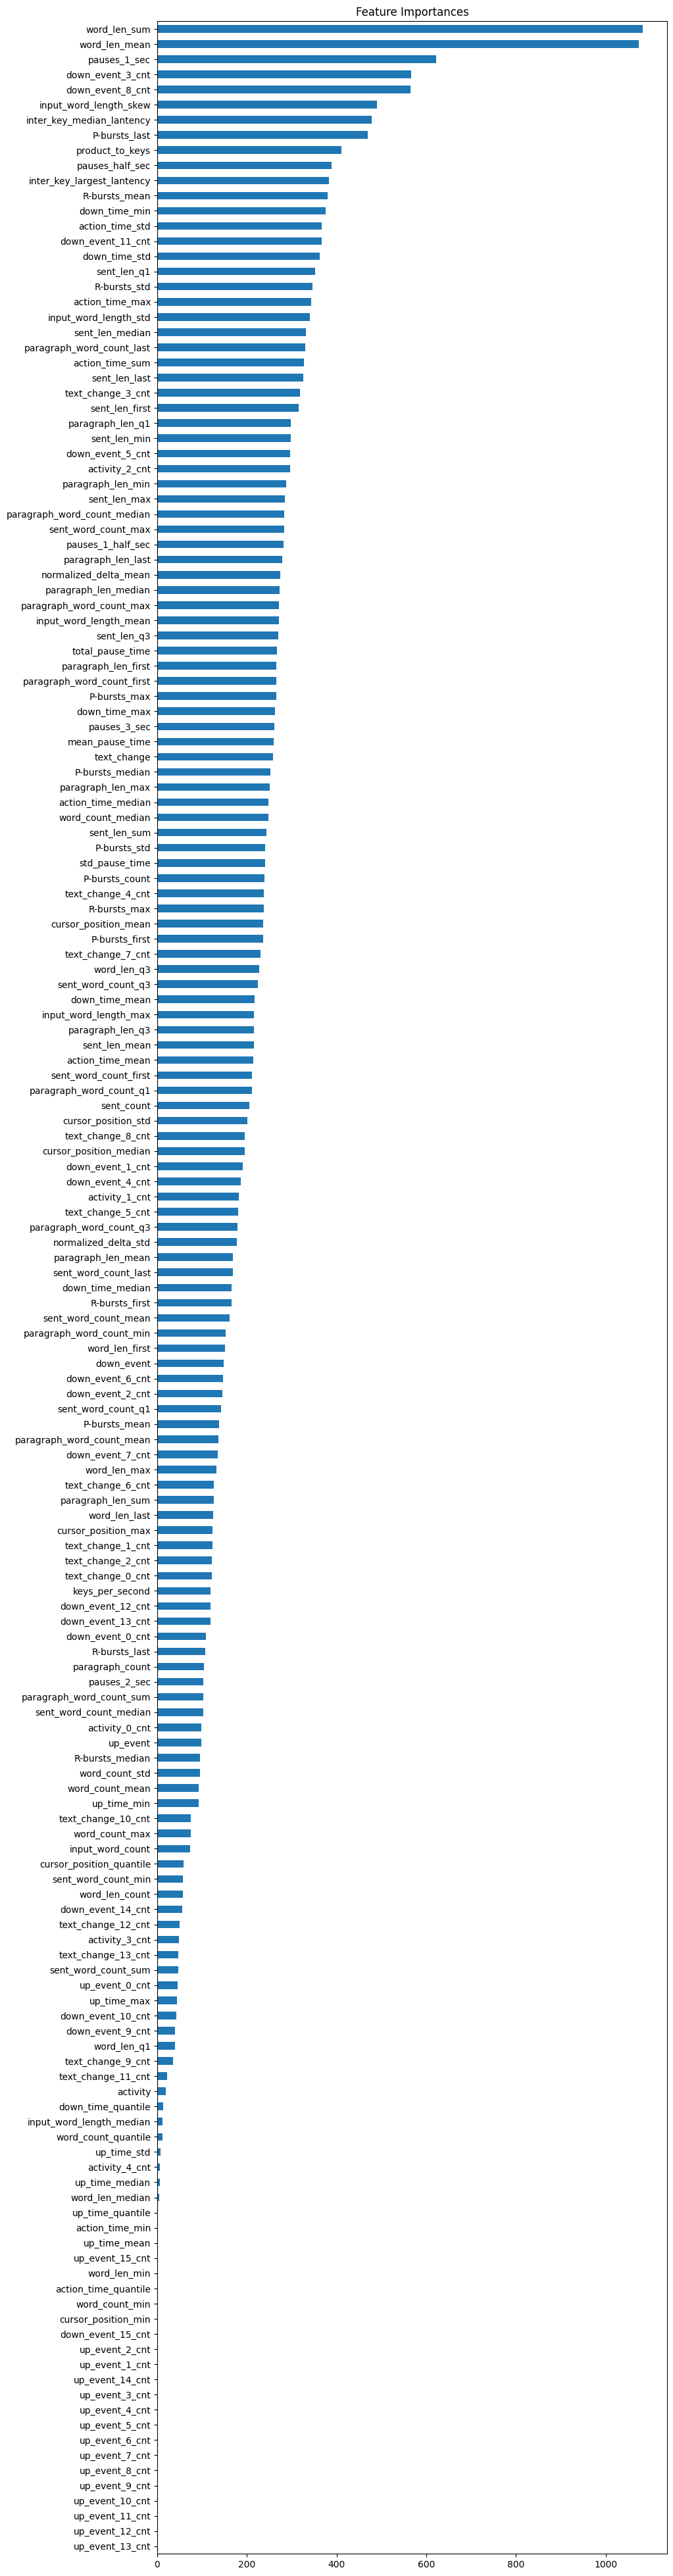

In [18]:
data_path     = '/kaggle/input/linking-writing-processes-to-writing-quality/'
train_logs    = pl.scan_csv(data_path + 'train_logs.csv')
train_feats   = dev_feats(train_logs)
train_feats   = train_feats.collect().to_pandas()

print('< Essay Reconstruction >')
train_logs             = train_logs.collect().to_pandas()
train_essays           = get_essay_df(train_logs)
train_feats            = train_feats.merge(word_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(sent_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(parag_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(get_keys_pressed_per_second(train_logs), on='id', how='left')
train_feats            = train_feats.merge(product_to_keys(train_logs, train_essays), on='id', how='left')


print('< Mapping >')
train_scores   = pd.read_csv(data_path + 'train_scores.csv')
data           = train_feats.merge(train_scores, on='id', how='left')
x              = data.drop(['id', 'score'], axis=1)
y              = data['score'].values
print(f'Number of features: {len(x.columns)}')


print('< Testing Data >')
test_logs   = pl.scan_csv(data_path + 'test_logs.csv')
test_feats  = dev_feats(test_logs)
test_feats  = test_feats.collect().to_pandas()

test_logs             = test_logs.collect().to_pandas()
test_essays           = get_essay_df(test_logs)
test_feats            = test_feats.merge(word_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(sent_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(parag_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(get_keys_pressed_per_second(test_logs), on='id', how='left')
test_feats            = test_feats.merge(product_to_keys(test_logs, test_essays), on='id', how='left')


test_ids = test_feats['id'].values
testin_x = test_feats.drop(['id'], axis=1)

print('< Learning and Evaluation >')
param = {'n_estimators': 1024,
         'learning_rate': 0.005,
         'metric': 'rmse',
         'random_state': 42,
         'force_col_wise': True,
         'verbosity': 0,}
solution = LGBMRegressor(**param)
y_pred   = evaluate(x.copy(), y.copy(), solution, test_x=testin_x.copy()) 

sub = pd.DataFrame({'id': test_ids, 'score': y_pred})
sub.to_csv('submission.csv', index=False)

In [11]:
sub

,id,score
0,0000aaaa,1.279185
1,2222bbbb,1.285037
2,4444cccc,1.282282
